---
title: Solving Four-Bar Constraints
type: submodule
---
# Solving Four-Bar Constraints


Turn on inline plotting

In [1]:
%matplotlib inline

import required packages

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
#from pynamics.body import Body
#from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize


Create a pynamics system

In [3]:
system = System()
pynamics.set_system(__name__,system)

Declare constants

In [4]:
lA = Constant(2,'lA',system)
lB = Constant(1.5,'lB',system)
lC = Constant(1,'lC',system)
lD = Constant(1,'lD',system)

Create three differentiable state variables

In [5]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

Create an initial guess for their starting positions.  Note that this is not necessarily accurate given the constraint that they are supposed to be connected with given, constant length.  We will use these initial values to seed the solver that will find a valid initial state

In [6]:
initialvalues = {}
initialvalues[qA]=-90*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=90*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=90*pi/180
initialvalues[qC_d]=0*pi/180

Retrieve state variables in the order they are stored in the system

In [7]:
statevariables = system.get_state_variables()

Create four frames

In [8]:
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')

Declare N as the Newtonian (fixed) frame

In [9]:
system.set_newtonian(N)

Rotate A,B, and C about their local Z axes.

In [10]:
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)

Define vectors that will be used to solve for kinematics.  Note: this can be done several possible ways as in the figure below:

![Four Bar Representations](../../../sketches/four-bar-representations.png)

Define my rigid body kinematics

In [11]:
pNA=0*N.x+0*N.y+0*N.z

pAB=pNA+lA*A.x

pBC = pAB + lB*B.x

pCtip = pBC + lC*C.x

pD = lD*N.x

In [12]:
type(pNA)

pynamics.vector.Vector

In [13]:
type(A)

pynamics.frame.Frame

In [14]:
type(A.x)

pynamics.vector.Vector

In [15]:
pout = pAB + 3*B.x-2*B.y

Declare a list of points that will be used for plotting

In [16]:
points = [pNA,pAB,pBC,pCtip]

create a list of initial values ini0 in the order of the system's state variables

In [17]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Define the closed loop kinematics of the four bar linkage.

In [18]:
eq_vector = pCtip-pD

Dot the vector equation with N.x and N.y to create two scalar equations.  This will remove two degrees of freedom from our system.

In [19]:
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]

## Solve for valid initial condition determined by independent variable

identify independent and dependent variables

In [20]:
qi = [qA]
qd = [qB,qC]

for dependent variables, create an initial guess

Create a copy of symbolic constants dictionary and add the initial value of qi to it

In [21]:
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

substitute constants in equation

In [22]:
eq = [item.subs(constants) for item in eq]

convert to numpy array

sum the error

In [23]:
error = (numpy.array(eq)**2).sum()

Convert to a function that scipy can use.  Sympy has a "labmdify" function that evaluates an expression, but scipy needs a slightly different format.

In [24]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables

In [25]:
guess = [initialvalues[item] for item in qd]

In [26]:
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

In [27]:
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2021-02-15 16:31:49,166 - pynamics.output - INFO - calculating outputs
2021-02-15 16:31:49,167 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

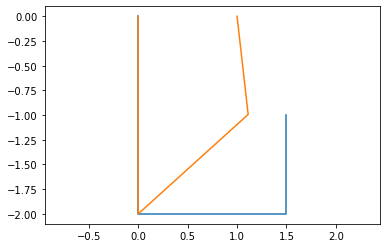

In [28]:
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
points.plot_time()

In [29]:
result.fun

5.147432205526916e-14

## Find Internal Jacobian

Now, given a valid configuration, solve for the linearized, velocity-based constraint equation.  If 

$$eq = \textbf{A} q_i + \textbf{B} q_d = 0$$
then, solving for $q_d$, 
$$-\textbf{B}q_d = \textbf{A}q_i$$
$$q_d = -\textbf{B}^{-1}\textbf{A}q_i$$

Turn constraint equations into a vector

In [30]:
eq_d = sympy.Matrix(eq_d)

Turn qi and qd into sympy vectors

In [31]:
qi = sympy.Matrix([qA_d])
qd = sympy.Matrix([qB_d,qC_d])

take partial derivative of constraints with respect to independent and dependent variables:

In [32]:
AA = eq_d.jacobian(qi)
BB = eq_d.jacobian(qd)

Solve for internal input/output Jacobian

In [33]:
J = -BB.inv()*AA
J

⎡                                                       (-sin(qA)⋅sin(qB)⋅sin(
⎢                                                     - ──────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢  (-lA⋅sin(qA) - lB⋅sin(qA)⋅cos(qB) - lB⋅sin(qB)⋅cos(qA) + lC⋅(sin(qA)⋅sin(qB
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎣                                                                             

qC) + sin(qA)⋅cos(qB)⋅cos(qC) + sin(qB)⋅cos(qA)⋅cos(qC) + sin(qC)⋅cos(qA)⋅cos(
──────────────────────────────────────────────────────────────────────────────
                                                     2        2               
                                               lB⋅s

That expression is quite long.  We can use the simplify function provided by sympy to shorten the expression:

In [34]:
J.simplify()
J

⎡ ⎛lA⋅sin(qB)                  ⎞  ⎤
⎢-⎜────────── + lA⋅cos(qB) + lB⎟  ⎥
⎢ ⎝ tan(qC)                    ⎠  ⎥
⎢──────────────────────────────── ⎥
⎢               lB                ⎥
⎢                                 ⎥
⎢lA⋅(lB⋅sin(qB) + lC⋅sin(qB + qC))⎥
⎢─────────────────────────────────⎥
⎣          lB⋅lC⋅sin(qC)          ⎦

Solving for the dependent variables $q_d$:

In [35]:
qd2 = J*qi
qd2

⎡      ⎛lA⋅sin(qB)                  ⎞  ⎤
⎢-qA_d⋅⎜────────── + lA⋅cos(qB) + lB⎟  ⎥
⎢      ⎝ tan(qC)                    ⎠  ⎥
⎢───────────────────────────────────── ⎥
⎢                  lB                  ⎥
⎢                                      ⎥
⎢lA⋅qA_d⋅(lB⋅sin(qB) + lC⋅sin(qB + qC))⎥
⎢──────────────────────────────────────⎥
⎣            lB⋅lC⋅sin(qC)             ⎦

Now we can create a substitution dictionary to replace all occurrances of $\dot{q}_b$ and  $\dot{q}_c$

In [42]:
subs = dict([(ii,jj) for ii,jj in zip(qd,qd2)])
subs

⎧            ⎛lA⋅sin(qB)                  ⎞                                   
⎪      -qA_d⋅⎜────────── + lA⋅cos(qB) + lB⎟                                   
⎨            ⎝ tan(qC)                    ⎠         lA⋅qA_d⋅(lB⋅sin(qB) + lC⋅s
⎪qB_d: ─────────────────────────────────────, qC_d: ──────────────────────────
⎩                        lB                                     lB⋅lC⋅sin(qC) 

            ⎫
            ⎪
in(qB + qC))⎬
────────────⎪
            ⎭

Now pick an end-effector

In [43]:
pout

lA*A.x + 3*B.x - 2*B.y

In [44]:
vout = pout.time_derivative()

In [45]:
vout

lA*qA_d*A.y + B.x*(2*qA_d + 2*qB_d) + B.y*(3*qA_d + 3*qB_d)

In [46]:
vout = vout.subs(subs)

In [47]:
vout

lA*qA_d*A.y + B.x*(2*qA_d - 2*qA_d*(lA*sin(qB)/tan(qC) + lA*cos(qB) + lB)/lB) + B.y*(3*qA_d - 3*qA_d*(lA*sin(qB)/tan(qC) + lA*cos(qB) + lB)/lB)